# Codeando un Transformer!
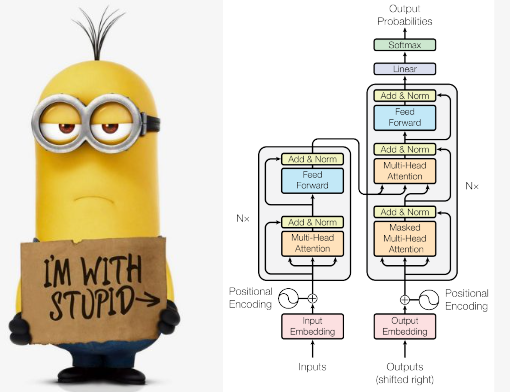


## Introducción
Al fin! Lo que todos estábamos esperando. Ahora que sabemos como funciona el mecanismo de Attention tenemos casi todos los componentes que hacen falta para construir un Transformer (la T en GPT). A pesar de los memes que andan dando vuelta, no tienen ninguna relación con los dibujitos. Se llaman Transformers por que en el paper *Attention is all you need* se usan para transformar texto, de un idioma a otro.

Vamos a estar creando algunos transformers pequeños, de algunos cientos de miles de parámetros. Es posible replicar esta parte usando solo CPU, aunque puede llevar algo más de tiempo. El ejemplo del final es un transformer con 7.27 millones de parámetros. Para entrenar este transformer si es necesario usar GPU (entrenar en CPU solo es posible pero lleva días). Usando una GPU de notebook (NVIDIA 1660 TI mobile 6 GB VRAM) se logran 1000 steps en 7.5 minutos (hacer 10K steps lleva cerca de una hora y media). Para aquellos que no puedan replicar esta parte del código, voy a hacer disponibles algunos modelos pre-entrenados los cuales pueden cargar para hacer inferencia usando solo CPU sin problemas.

Esta clase está dividida en seis secciones:
1. Vamos a cambiar la forma de samplear los datos de entrenamiento respecto a la forma que veniamos haciendo. Esto es necesario para poder entrenar el transformer pero además nos va a permitir cambiar el texto de entrenamiento más fácilmente.
2. Vamos a crear todos los componentes de la primer versión del transformer usando los modulos que habíamos creado. Necesitamos Linear, Tanh, Embedding, BatchNorm. Además vamos a implementar Dropout, LayerNorm, SelfAttention, MultiHead Self Attention y el Transformer Block.
3. Vamos a cambiar el algoritmo de optimización de SGD a Adam usando `torch.optim`.
4. Vamos a reescribir los componentes del transformer usando `nn.Module` de torch.
5. Vamos a agrandar el modelo y entrenar usando otros datasets.
6. Voy es extenderme en algunas conclusiones y notas antes de presentarles los ejercicios.

Follow me!

## Código inicial - leyendo texto del dataset.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

In [2]:
import idna

def punyencode(text: str) -> str:
    """Encodes a UTF-8 string to its Punycode representation, handling spaces by encoding each word separately."""
    
    return " ".join([idna.encode(word).decode('ascii') for word in text.split()])
    
def punydecode(punycode: str) -> str:
    """Decodes a Punycode string back to UTF-8."""
    return " ".join([idna.decode(word) for word in punycode.split()])

def process_name(name):
    name = name.lower()
    for n in name.split():
        if len(n) < 2:
            return ''
    try:
        return punyencode(name)
    except:
        return ''

dataset = open("data/city_names_full.txt", 'r').read().split('\n')
with open('data/city_names_puny.txt', 'w') as f:
    for n in dataset:
        name = process_name(n)
        if name != '':
            f.write(name+'\n')
dataset = open("data/city_names_puny.txt", 'r').read().split('\n')
puny = [x for x in dataset if 'xn--' in x]
nopuny = [x for x in dataset if 'xn--' not in x]

In [3]:
# ----- Guardar el dataset de nombres no puny
with open('data/city_names_nopuny.txt', 'w') as f:
    for name in nopuny:
        f.write(name+'\n')

In [195]:
#with open('data/city_names_full.txt','r', encoding='utf-8') as f:
with open('data/donquixote.txt','r', encoding='utf-8') as f:
#with open('data/martinfierro.txt','r', encoding='utf-8') as f:
    text = f.read()

In [196]:
chars = sorted(list(set(text)))
charset_size =  len(chars)

stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s:[stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [197]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [75]:
def get_batch(split='train'):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_size, (batch_size,))
    x = torch.stack([data[i:i+context_size] for i in ix])
    y = torch.stack([data[i+1:i+context_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [198]:
len(text), charset_size

(2130021, 110)

### Definiendo hiperparámetros

In [22]:
# -----  Hiperparámetros del modelo
context_size = 128
emb_size = 64
n_hidden = 128
att_head_size = 256
num_heads = 8
num_blocks = 3
dropout = 0.2

# ----- Parámetros de training
batch_size = 64
steps = 20001
eval_interval = 100
learning_rate = 1e-3
eval_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

'NVIDIA GeForce GTX 1660 Ti'

In [25]:
x, y = get_batch()

In [36]:
torch.manual_seed(42)
torch.randint(len(data) - context_size, (batch_size,))

tensor([ 569766,  927203,  798700,  919630, 1070634,  642695,  265276, 1052132,
         474022,   63401,  370450,  489478,  192266,  254250,  625047, 1158580,
        1040483,  196423,  971799,  977074,  430357,  342548,  151249,  909479,
        1151099, 1108285,  425285,  900897,  115183,  625387,  789588,  461760,
         460891, 1089865,  561749, 1023100,  290891,   75560,  779104,  640026,
         725786,  569742,  372937,   30015, 1045371,  783131,  880511,  201646,
          42285,  576029,  983646,  680781, 1015234,  379755,  581734, 1155619,
         330463,  756344,  327410,  725316,  551906,  249654,  455876,  554872])

In [43]:
torch.manual_seed(42)
x, y = get_batch()

tensor([ 833744,  968877, 1092828,  440450,  864544,   72530,   52218, 1083354,
         359989,  208924,  256417,  494704,  928456,  644857,  914753,  320685,
         705352, 1059242,  397882,   33588,  431429,  345496, 1057350,  825060,
          94920,  546428,  314200,   45582,  124697,   66344,  310408,  616261,
         232423,  877477,  467012,  656881, 1046645,   76766,  427759,  545289,
         635605,  712853,  869001,  276841, 1060647, 1078465,  899673,   91633,
         188344,  947340,  535956,  102174,  903479,  766342,  364254, 1084868,
         728038, 1025146,  452029,  525926,  828078, 1018406, 1075755,  456249])


In [34]:
decode(y[0].tolist())

'e mogili\ndryanovo\nbratsigovo\ntoviklin\ngustavia\nmontero\nla paz\nhuachacalla\nsan julian\nvigia\nparelhas\nparaibano\nparagominas\nmoreno'

In [44]:
decode(train_data[833744:833744+128].tolist())

've mogili\ndryanovo\nbratsigovo\ntoviklin\ngustavia\nmontero\nla paz\nhuachacalla\nsan julian\nvigia\nparelhas\nparaibano\nparagominas\nmoren'

In [41]:
text.find('ve mogili')

833744

### Los componentes básicos

In [91]:
class Linear:
    def __init__(self, input_dim, output_dim, bias=True, device='cpu'):
        self.W = torch.randn(input_dim, output_dim).to(device=device)/(input_dim ** 0.5)
        self.b = torch.zeros(output_dim).to(device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])

    def __repr__(self):
        return f'Linear({self.W.shape})'

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []   

class Embedding:
    def __init__(self, vocab_size, embedding_size, device='cpu'):
        self.w = torch.randn(vocab_size, embedding_size).to(device=device)

    def __call__(self, x):
        self.out = self.w[x]
        return self.out

    def parameters(self):
        return [self.w]

    def __repr__(self):
        return f'Embedding({self.w.shape}):'

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [142]:
class LayerNorm:
    def __init__(self, input_size, eps=0.00005, device='cpu'):
        self.eps = eps
        # los parametros
        self.gamma = torch.ones(input_size).to(device=device)
        self.beta = torch.zeros(input_size).to(device=device)

    def __call__(self, x):
        xmean = x.mean(1, keepdims=True)
        xstd = x.std(1, keepdims=True)
        # normalizamos x para que tenga distribución N(0, 1)
        xhat = (x - xmean)/ (xstd + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class SelfAttentionHead:
    def __init__(self, feature_size, head_size, device='cpu'):
        self.fs = feature_size
        self.hs = head_size
        self.device = device

        self.key = Linear(self.fs, self.hs, bias=False, device=device)
        self.query = Linear(self.fs, self.hs, bias=False, device=device)
        self.value = Linear(self.fs, self.hs, bias=False, device=device)
        self.layers = [self.key, self.query, self.value]

    def __call__(self, x, mask=True):
        B, T, C = x.shape
        tril = torch.tril(torch.ones(T,T)).to(self.device)
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -.5
        if mask:
            wei = wei.masked_fill(tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        out = wei @ v
        return out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def __repr__(self):
        return f'SelfAttentionHead(key:{self.key}, query:{self.query}, value:{self.value})'

class MultiHeadAttention:
    def __init__(self, num_heads, feature_size, head_size, device='cpu'):
        self.num_heads = num_heads
        self.feature_size = feature_size
        self.head_size = head_size

        self.heads = [SelfAttentionHead(self.feature_size, self.head_size, device=device) for _ in range(self.num_heads)]
        self.proj = Linear(self.feature_size, self.feature_size, device=device)
        self.layers = self.heads + [self.proj]

    def __call__(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def __repr__(self):
        return f'MultiHeadAttention({self.num_heads} x {self.heads[0]})\n proj({self.proj})'

class FeedForward:
    def __init__(self, feature_size, device='cpu'):
        self.fs = feature_size
        self.linear1 = Linear(self.fs, self.fs*4, bias=True, device=device)
        self.act = Tanh() # GeLU, SWeLU
        self.linear2 = Linear(self.fs*4, self.fs, bias=True, device=device)
        self.layers = [self.linear1, self.act, self.linear2]

    def __call__(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def __repr__(self):
        return f'FeadForward({self.linear1}, {self.linear2})\n)'



class TransformerDecoderBlock:
    def __init__(self, num_heads, feature_size, device='cpu'):
        self.num_heads = num_heads
        self.feature_size = feature_size
        self.head_size = self.feature_size // self.num_heads

        self.att = MultiHeadAttention(self.num_heads, self.feature_size, self.head_size, device=device)
        self.ffn = FeedForward(self.feature_size, device=device)
        self.ln1 = nn.LayerNorm(self.feature_size, device=device)
        self.ln2 = nn.LayerNorm(self.feature_size, device=device)
        
        self.layers = [self.att, self.ffn, self.ln1, self.ln2]
    
    def __call__(self, x):
        x = x + self.att(self.ln1(x))
        out = x + self.ffn(self.ln2(x))
        return out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
    
    def __repr__(self):
        return f'TransformerBlock({self.att}\n{self.ffn}\n{self.ln1}\n{self.ln2})'    

In [133]:
context_size // num_heads

16

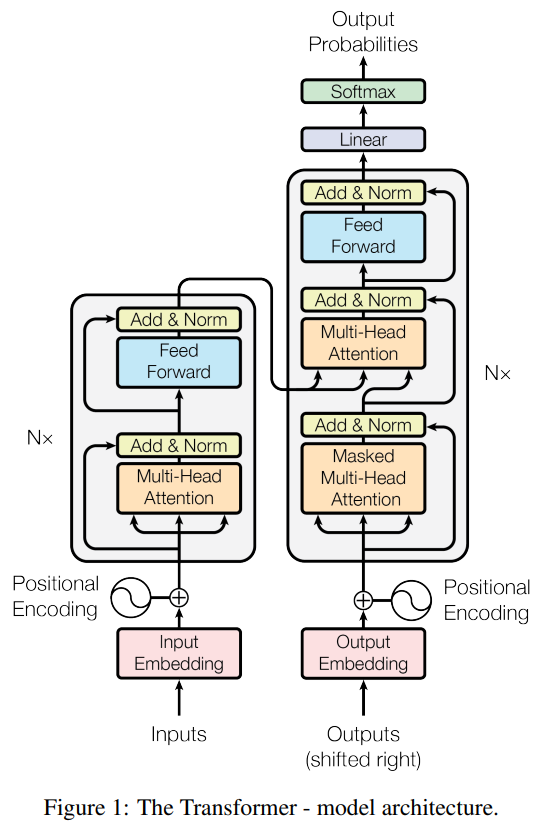

### El modelo

In [149]:
class NameGenerator:
    def __init__(self, charset_size, context_size, emb_size, num_heads, device='cpu'):
        self.charset_size = charset_size
        self.context_size = context_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.device = device

        self.chr_emb = Embedding(self.charset_size, self.emb_size, device=device)
        self.pos_emb = Embedding(self.context_size, self.emb_size, device=device)
        self.att_head1 = TransformerDecoderBlock(self.num_heads, self.emb_size, device=device)
        self.att_head2 = TransformerDecoderBlock(self.num_heads, self.emb_size, device=device)
        self.att_head3 = TransformerDecoderBlock(self.num_heads, self.emb_size, device=device)
        self.linear = Linear(self.emb_size, self.charset_size, device=device)
        self.layers = [self.chr_emb, self.pos_emb, self.att_head1, self.att_head2, self.att_head3, self.linear]

        for p in self.parameters():
            p.requires_grad = True

    def __call__(self, x):
        B, T = x.shape
        emb = self.chr_emb(x)
        pos = self.pos_emb(torch.arange(T, device=self.device))
        emb = emb + pos
        x = self.att_head1(emb)
        x = self.att_head2(x)
        x = self.att_head3(x)
        logits = self.linear(x)
        return logits
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def count_parameters(self):
        return sum([p.nelement() for p in self.parameters()])
    
    def generate(self, idx, max_new_tokens):
        #idx is (B, T) array of indexes in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.context_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]  # becomes (B, C)
            probs = F.softmax(logits, dim=--1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [150]:
torch.manual_seed(42)
model = NameGenerator(charset_size, context_size, emb_size, num_heads, device)
model.count_parameters()

162728

In [154]:
lr = 0.01
st_time = time.time()
losses = []
val_losses = []
for i in range(steps):
    # 1. Forwards pass
    Xtr, Ytr = get_batch()
    Xva, Yva = get_batch('validation')

    logits = model(Xtr).view(batch_size*context_size, charset_size)
    Y = Ytr.view(batch_size*context_size)

    # 2. loss
    loss = F.cross_entropy(logits, Y)

    # 3. zero grad
    for p in model.parameters():
        p.grad = None
    
    # 4. backward pass
    loss.backward()

    # 5. update
    if i > 2000 and i < 5000: # learing rate decay
        lr = 0.001
    if i > 7500:
        lr = 0.0005
    for p in model.parameters():
        p.data -= p.grad * lr

    if i%1000 == 0:
        with torch.no_grad():
            val_logits = model(Xva).view(batch_size*context_size, charset_size)
            val_Y = Yva.view(batch_size*context_size)
            val_loss = F.cross_entropy(val_logits, val_Y)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            print(f'epoch {i}/{steps} loss: {loss.item():0.4f} val_loss: {val_loss.item():0.4f}  time/1K step: {(time.time() - st_time):0.4f}')
            st_time = time.time()

epoch 0/20001 loss: 5.3385 val_loss: 5.2355  time/1K step: 0.0608
epoch 1000/20001 loss: 2.8477 val_loss: 2.8337  time/1K step: 33.6092
epoch 2000/20001 loss: 2.7859 val_loss: 2.7811  time/1K step: 36.2196


KeyboardInterrupt: 

In [151]:
print('Test generation >>>>>>>>>')
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=300)[0].tolist()))
print('<<<<<<<<<<<<<<<<< END')

Test generation >>>>>>>>>

3j5u 617qw8e2wc1b-7u-e21ixsnw weptnts01rwt6 d5iw
2gxydjowho3l9x9ej5q2cd9tr4lhghso.8ioc3jg
09tm0iwvyk0b-75ymjvsl
2qati02tgn0btdeesf17he9esxsn00snzu9fp qe y9eeelelge6esn0s46e3gu4je4meleess02ntu550depew 0oefoe0se e-2ee-eyc3ydeex9oe-eew.qeg1qhf7fo5fefp6j5rrevec0acy6jxf7foeo9ve elyfpwfn.elguf17.qepwhqefk
<<<<<<<<<<<<<<<<< END


In [155]:
print('Test generation >>>>>>>>>')
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=300)[0].tolist()))
print('<<<<<<<<<<<<<<<<< END')

Test generation >>>>>>>>>

gisovenkli
hlakerolanolo
kan
dan
nertiay
rerpsm
zhia
spebao
sa
st
pa
mpon-ltwhckuu ikriadge
mbeskurr
cub da
eeaolftesa
acanangsh
sadeelenaromhakleeumbe
loruririgoasuzechare
wiclera
boingololdeleepicinguoiodoocamardaixsiabaingonglatelorutenomelert lhitibolig
b
pimoronolip
hopilanolblllb
jchaulla
emil
<<<<<<<<<<<<<<<<< END


### Mejorando el optimizador

In [156]:
torch.manual_seed(42)
model = NameGenerator(charset_size, context_size, emb_size, num_heads, device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
model.count_parameters()

162728

In [158]:
st_time = time.time()
for step in range(steps):
    # forward
    xb, yb = get_batch()
    logits = model(xb)
    # loss
    loss = F.cross_entropy(logits.view(batch_size*context_size, charset_size), yb.view(batch_size*context_size))
    # zero grad
    optimizer.zero_grad(set_to_none=True)
    # backward
    loss.backward()
    #update
    optimizer.step()
    if step % 1000 == 0:
        with torch.no_grad():
            Xva, Yva = get_batch('validation')
            val_logits = model(Xva).view(batch_size*context_size, charset_size)
            val_Y = Yva.view(batch_size*context_size)
            val_loss = F.cross_entropy(val_logits, val_Y)
        print(f'epoch {step}/{steps} loss: {loss.item():0.4f} val_loss: {val_loss.item():0.4f}  time/1K step: {(time.time() - st_time):0.4f}')
        st_time = time.time()

epoch 0/20001 loss: 5.3385 val_loss: 4.7864  time/1K step: 0.0935
epoch 1000/20001 loss: 2.3783 val_loss: 2.3961  time/1K step: 31.3019
epoch 2000/20001 loss: 2.2365 val_loss: 2.1478  time/1K step: 33.2409
epoch 3000/20001 loss: 2.0565 val_loss: 2.0634  time/1K step: 35.0908
epoch 4000/20001 loss: 2.0632 val_loss: 2.0379  time/1K step: 37.1552
epoch 5000/20001 loss: 2.0546 val_loss: 2.0309  time/1K step: 35.7550


KeyboardInterrupt: 

In [159]:
training=False
print('Test generation >>>>>>>>>')
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=200)[0].tolist()))
print('<<<<<<<<<<<<<<<<< END')

Test generation >>>>>>>>>

ieng beaquie
conces
orasington
eacoycotrone
saint-germont
ongxing
onneublang
shaoncion
orouate
indiosse
genjusi
guatoin
gedamde
ganose
guessiling
gandaluy
guenne
eglinas
erogubia
demerssid
dian
demin

<<<<<<<<<<<<<<<<< END


## Migrando a PyTorch

In [160]:
class SelfAttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_size, context_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C **-.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_head, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(n_embd, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class TransformerDecoderBlock(nn.Module):
    def __init__(self, n_head, n_embd):
        super().__init__()
        head_size = n_embd // n_head     # el tamaño del embedding debe ser multiplo de la cantidad de heads
        self.sa = MultiHeadAttention(n_head, n_embd, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [161]:
class NameGenerator(nn.Module):
    def __init__(self, charset_size, context_size, emb_size, num_heads):
        super().__init__()
        self.charset_size = charset_size
        self.context_size = context_size
        self.emb_size = emb_size
        #self.hidden_size = hidden_size
        self.att_head_size = att_head_size
        self.num_heads = num_heads
        
        self.chr_emb = nn.Embedding(self.charset_size, self.emb_size)
        self.pos_emb = nn.Embedding(self.context_size, self.emb_size)
        self.att_head1 = TransformerDecoderBlock(self.num_heads, self.emb_size)
        self.att_head2 = TransformerDecoderBlock(self.num_heads, self.emb_size)
        self.att_head3 = TransformerDecoderBlock(self.num_heads, self.emb_size)
        self.linear = nn.Linear(self.emb_size, self.charset_size)
        
        for p in self.parameters():
            p.requires_grad = True

    def forward(self, x):
        B, T = x.shape
        emb = self.chr_emb(x)
        pos = self.pos_emb(torch.arange(T, device=device))
        emb = emb + pos
        x = self.att_head1(emb)
        x = self.att_head2(x)
        x = self.att_head3(x)
        logits = self.linear(x)
        return logits
    
    def count_parameters(self):
        return sum([p.nelement() for p in self.parameters()])

    def generate(self, idx, max_new_tokens):
        #idx is (B, T) array of indexes in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.context_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]  # becomes (B, C)
            probs = F.softmax(logits, dim=--1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [162]:
torch.manual_seed(42)
model = NameGenerator(charset_size, context_size, emb_size, num_heads)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
model.to(device)
model.count_parameters()

162728

In [164]:
st_time = time.time()
for step in range(10000):
    # forward
    xb, yb = get_batch()
    logits = model(xb)
    # loss
    loss = F.cross_entropy(logits.view(batch_size*context_size, charset_size), yb.view(batch_size*context_size))
    # zero grad
    optimizer.zero_grad(set_to_none=True)
    # backward
    loss.backward()
    #update
    optimizer.step()
    if step % 1000 == 0:
        with torch.no_grad():
            Xva, Yva = get_batch('validation')
            val_logits = model(Xva).view(batch_size*context_size, charset_size)
            val_Y = Yva.view(batch_size*context_size)
            val_loss = F.cross_entropy(val_logits, val_Y)
        print(f'epoch {step}/{steps} loss: {loss.item():0.4f} val_loss: {val_loss.item():0.4f}  time/1K step: {(time.time() - st_time):0.4f}')
        st_time = time.time()

epoch 0/20001 loss: 3.9873 val_loss: 3.8162  time/1K step: 0.0711
epoch 1000/20001 loss: 2.4331 val_loss: 2.4508  time/1K step: 32.8131
epoch 2000/20001 loss: 2.3709 val_loss: 2.2956  time/1K step: 34.5931
epoch 3000/20001 loss: 2.2438 val_loss: 2.2846  time/1K step: 38.6308
epoch 4000/20001 loss: 2.2214 val_loss: 2.1376  time/1K step: 38.6039
epoch 5000/20001 loss: 2.1322 val_loss: 2.1029  time/1K step: 40.5628
epoch 6000/20001 loss: 2.0663 val_loss: 2.1078  time/1K step: 42.5301
epoch 7000/20001 loss: 2.0736 val_loss: 2.1083  time/1K step: 43.0938
epoch 8000/20001 loss: 2.0804 val_loss: 1.9897  time/1K step: 36.2900
epoch 9000/20001 loss: 2.0720 val_loss: 2.0741  time/1K step: 34.6503


In [173]:
model.eval()
torch.manual_seed(42)
print('Test generation >>>>>>>>>')
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=300)[0].tolist()))
print('<<<<<<<<<<<<<<<<< END')

Test generation >>>>>>>>>

cendiew
qinemcon
churesad
bulawe
coystown
chaniton
bookown
clara
jonyndala
losham
citer
domata
liversburg
munga
kumbodhug
damdeerand
ehrunstown
burgel
buyloue
broek soaslandge
cammeles
chinter
chempton
chonsville
crachill
calton
catantion
carceme
bramare
braach
cay
conowville
cawmn
elmur north hills
<<<<<<<<<<<<<<<<< END


In [168]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            loss = F.cross_entropy(logits.view(batch_size*context_size, charset_size), Y.view(batch_size*context_size))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    loss = out['train']
    val_loss = out['val']
    return loss, val_loss

## Agrandando el modelo

[GPT 2 - Paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

In [199]:
# -----  Hiperparámetros del modelo
context_size = 256
emb_size = 384
num_heads = 6
num_blocks = 4
dropout = 0.2

# ----- Parámetros de training
batch_size = 64
steps = 10001
eval_interval = 100
learning_rate = 1e-3
eval_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [202]:
class NameGenerator(nn.Module):
    def __init__(self, charset_size, context_size, emb_size, num_heads):
        super().__init__()
        self.charset_size = charset_size
        self.context_size = context_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        self.chr_emb = nn.Embedding(self.charset_size, self.emb_size)
        self.pos_emb = nn.Embedding(self.context_size, self.emb_size)
        self.blocks = nn.Sequential(*[TransformerDecoderBlock(self.num_heads, self.emb_size) for _ in range(num_blocks)])
        self.linear = nn.Linear(self.emb_size, self.charset_size)

        for p in self.parameters():
            p.requires_grad = True

    def forward(self, x):
        B, T = x.shape
        emb = self.chr_emb(x)
        pos = self.pos_emb(torch.arange(T, device=device))
        emb = emb + pos
        x = self.blocks(emb)
        logits = self.linear(x)
        return logits 
    
    def count_parameters(self):
        return sum([p.nelement() for p in self.parameters()])

    def generate(self, idx, max_new_tokens):
        #idx is (B, T) array of indexes in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.context_size:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]  # becomes (B, C)
            probs = F.softmax(logits, dim=--1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [203]:
torch.manual_seed(42)
model = NameGenerator(charset_size, context_size, emb_size, num_heads)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
model.to(device)
model.count_parameters()

7276142

In [178]:
st_time = time.time()
for step in range(steps):
    
    xb, yb = get_batch()

    logits = model(xb)
    loss = F.cross_entropy(logits.view(batch_size*context_size, charset_size), yb.view(batch_size*context_size))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if step % 1000 == 0:
        with torch.no_grad():
            loss, val_loss = estimate_loss()
        print(f'epoch {step}/{steps} loss: {loss.item():0.4f} val_loss: {val_loss.item():0.4f}  time/1K step: {(time.time() - st_time):0.4f}')
        st_time = time.time()

epoch 0/10001 loss: 6.3403 val_loss: 6.3428  time/1K step: 27.0863


KeyboardInterrupt: 

### Salvando y restaurando el modelo

In [205]:
torch.save(model, 'models/untrained')

In [210]:
model = torch.load('models/mfierro.pt')

/tmp/ipykernel_484445/3216374323.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/mfierro.pt')


In [212]:
torch.manual_seed(42)
print('Test generation >>>>>>>>>')
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))
print('<<<<<<<<<<<<<<<<< END')

Test generation >>>>>>>>>

siempre es muy larga querida.

1116
Ya se ha de decirse la vida,
mas todavÑa falta el rabo,
y por lo visto no acabo
de salir de esta jarana;
pues esto es lo que se llama
remacharsele a uno el clavo.


XXXI

1143
Y despuÍs de estas palabras
que ya la intenciÚn revelan,
procurando los presentes
que no se armara pendencia,
se pusieron de por medio
y la cosa quedÚ quieta.
MartÑn Fierro y los muchachos,
evitando la contienda,
montaron y paso a paso,
como el que miedo no lleva,
a la costa de un arroyo
llegaron a echar pie a tierra.
Desensillaron los pingos
y se sentaron en rueda,
refiriÍndose entre sÑ
infinitas menudencias
porque tiene muchos cuentos
y muchos hijos la ausiencia.
AllÑ pasaron la noche
a la luz de las estrellas,
porque ese es un cortinao
que lo halla uno donde quiera,
y el gaucho sabe arreglarse
como ninguno se arregla:
el colchÚn son las caronas,
el lomillo es cabecera,
el cojinillo es blandura
y con el poncho o la jerga;
para salvar del rocÑo,
se c

1178
Y ya dejo el estrumento
con que he divertido a ustedes;
todos conocerlo pueden
que tuve costancia suma:
este es un botón de pluma
que no hay quien lo desenriede.

# Conclusiones
* Decoder only y diferencias con Encoder/Decoder.
* LMs overfitting y compresión de la entrada.
* Char level vs Token level
* Modelo fundacional vs Finetuning con RLHF (reinforcement learning with human feedback) vs Asistente
* Llama embeddings (RoPE)
* Mixture of Experts (MoE)
* Deepseek Transformers (MLA multiheat lattent attention)
* Como seguir con esto?

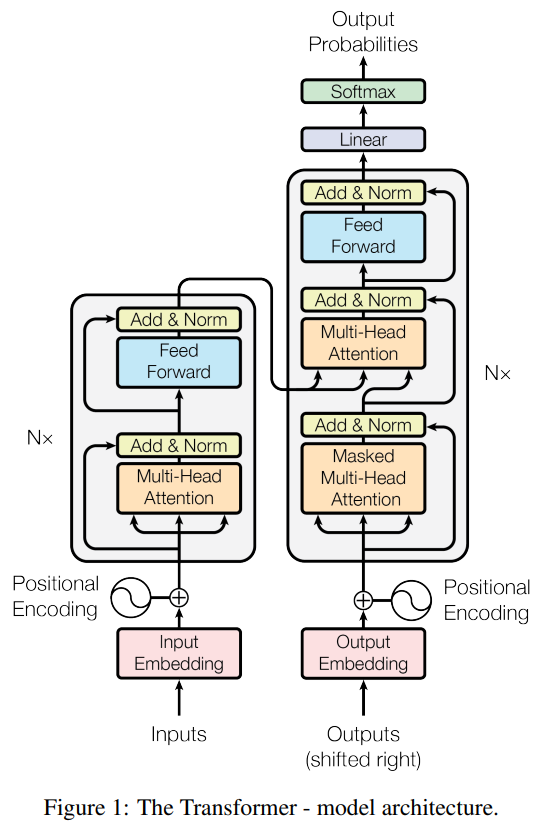

# Ejercicios


In [215]:
166015/1366

121.53367496339678